# NBA: Predicting WIn Shares For Top Ten Players

# Introduction

Question:Can we predict individual win shares of NBA players using other basketball metrics?

As a big fan of the NBA, people would use stats to explain their opinion on teams and players. The one stat that comes up in my mind is Win Shares. It's a player statistic which attempts to divvy up credit for team success to the individuals on the team. The formula is (PP-0.92*LPPP*(FGA+0.44*FTA+TO))/(0.32*LPPG*(TP/LP))+(MP/TMP*TDP*(1.08*LPPP-DRtg/100)/(0.32*LPPG*(TP/LP). The formula is explained by the bleacher report.(https://bleacherreport.com/articles/1040320-understanding-the-nba-explaining-advanced-comprehensive-stats-and-metrics#slide8). In simple terms, it shows how many wins that the player provides. So I'm finding out what other metrics are useful for predicting win shares.

The data I collected is  from the basketball-reference.com(https://www.basketball-reference.com/leagues/NBA_2019_advanced.html). I used the csv file of 2018-19 NBA Stats: Advanced.


# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from operator import itemgetter

# Uploading, Cleaning, and Describing Data

In [2]:
nba_data = pd.read_csv('NBA_2018-2019.csv')

In [3]:
nba_data.head()

,Player,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Álex Abrines,25,OKC,31,588,6.3,0.507,0.809,0.083,0.9,...,7.9,12.2,0.1,0.6,0.6,0.053,-2.4,-0.9,-3.4,-0.2
1,Quincy Acy,28,PHO,10,123,2.9,0.379,0.833,0.556,2.7,...,15.2,9.2,-0.1,0.0,-0.1,-0.022,-5.7,-0.3,-5.9,-0.1
2,Jaylen Adams,22,ATL,34,428,7.6,0.474,0.673,0.082,2.6,...,19.7,13.5,-0.1,0.2,0.1,0.011,-3.1,-1.3,-4.4,-0.3
3,Steven Adams,25,OKC,80,2669,18.5,0.591,0.002,0.361,14.7,...,12.6,16.4,5.1,4.0,9.1,0.163,0.6,2.1,2.7,3.2
4,Bam Adebayo,21,MIA,82,1913,17.9,0.623,0.031,0.465,9.2,...,17.1,15.8,3.4,3.4,6.8,0.171,-0.6,3.6,3.0,2.4


In [4]:
nba_data.shape

(708, 25)

There are 708 players that played in the 2018-2019 season. 

In [5]:
nba_data.dtypes
# This is the glossary that explains the acronym https://www.basketball-reference.com/about/glossary.html

Player     object
Age         int64
Tm         object
G           int64
MP          int64
PER       float64
TS%       float64
3PAr      float64
FTr       float64
ORB%      float64
DRB%      float64
TRB%      float64
AST%      float64
STL%      float64
BLK%      float64
TOV%      float64
USG%      float64
OWS       float64
DWS       float64
WS        float64
WS/48     float64
OBPM      float64
DBPM      float64
BPM       float64
VORP      float64
dtype: object

In [6]:
nba_data = nba_data.drop(['Tm',  'OWS', 'DWS', 'WS/48'], axis=1)
# Tm and Pos are catergorical variables and doesn't matter for the objective
# OWS, DWS, and WS/48 are part of the equation for WS. So it would be pointless. 

In [7]:
nba_data.columns

Index(['Player', 'Age', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'WS', 'OBPM', 'DBPM',
       'BPM', 'VORP'],
      dtype='object')

In [8]:
nba_data.head()

,Player,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,...,AST%,STL%,BLK%,TOV%,USG%,WS,OBPM,DBPM,BPM,VORP
0,Álex Abrines,25,31,588,6.3,0.507,0.809,0.083,0.9,7.8,...,4.3,1.3,0.9,7.9,12.2,0.6,-2.4,-0.9,-3.4,-0.2
1,Quincy Acy,28,10,123,2.9,0.379,0.833,0.556,2.7,20.1,...,8.2,0.4,2.7,15.2,9.2,-0.1,-5.7,-0.3,-5.9,-0.1
2,Jaylen Adams,22,34,428,7.6,0.474,0.673,0.082,2.6,12.3,...,19.8,1.5,1.0,19.7,13.5,0.1,-3.1,-1.3,-4.4,-0.3
3,Steven Adams,25,80,2669,18.5,0.591,0.002,0.361,14.7,14.8,...,6.6,2.0,2.4,12.6,16.4,9.1,0.6,2.1,2.7,3.2
4,Bam Adebayo,21,82,1913,17.9,0.623,0.031,0.465,9.2,24.0,...,14.2,1.8,3.0,17.1,15.8,6.8,-0.6,3.6,3.0,2.4


In [9]:
nba_data.isnull().sum()*100/nba_data.isnull().count()
# To check any nulls

Player    0.000000
Age       0.000000
G         0.000000
MP        0.000000
PER       0.000000
TS%       0.847458
3PAr      0.847458
FTr       0.847458
ORB%      0.000000
DRB%      0.000000
TRB%      0.000000
AST%      0.000000
STL%      0.000000
BLK%      0.000000
TOV%      0.847458
USG%      0.000000
WS        0.000000
OBPM      0.000000
DBPM      0.000000
BPM       0.000000
VORP      0.000000
dtype: float64

In [10]:
nba_data["TS%"].fillna(0, inplace =True)
nba_data["3PAr"].fillna(0, inplace =True)
nba_data["FTr"].fillna(0, inplace =True)
nba_data["TOV%"].fillna(0, inplace =True)
# Filled in the null with 0 since it's less than 1% null.

In [11]:
nba_data.isnull().sum()*100/nba_data.isnull().count()

Player    0.0
Age       0.0
G         0.0
MP        0.0
PER       0.0
TS%       0.0
3PAr      0.0
FTr       0.0
ORB%      0.0
DRB%      0.0
TRB%      0.0
AST%      0.0
STL%      0.0
BLK%      0.0
TOV%      0.0
USG%      0.0
WS        0.0
OBPM      0.0
DBPM      0.0
BPM       0.0
VORP      0.0
dtype: float64

There's no missing values in the data now.

In [12]:
nba_data.describe()
# Able to get a general overview of the columns stats

,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,WS,OBPM,DBPM,BPM,VORP
count,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000
mean,26.142655,42.882768,972.257062,12.745763,0.526973,0.376839,0.247192,4.979802,15.169068,10.071893,13.028107,1.484322,1.590960,11.919633,18.490678,1.968220,-1.511017,-0.578672,-2.091525,0.442514
std,4.141178,26.282043,802.770673,7.350963,0.123061,0.221680,0.178127,5.956338,8.297935,5.763570,8.953723,0.995191,1.662236,5.663598,5.686523,2.514443,4.165931,2.480814,5.320754,1.181068
min,19.000000,1.000000,1.000000,-38.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.700000,-36.100000,-20.500000,-52.300000,-2.200000
25%,23.000000,19.000000,245.250000,9.300000,0.499000,0.249250,0.153000,1.900000,9.900000,6.200000,7.100000,1.000000,0.500000,8.900000,15.000000,0.200000,-2.900000,-1.700000,-4.000000,-0.100000
50%,26.000000,44.000000,788.000000,12.400000,0.543500,0.388000,0.223000,3.300000,13.400000,8.700000,10.600000,1.400000,1.200000,11.500000,17.800000,1.100000,-1.250000,-0.600000,-1.700000,0.000000
75%,29.000000,68.000000,1579.500000,16.200000,0.581000,0.530000,0.309250,7.000000,19.200000,12.850000,17.325000,1.825000,2.125000,14.400000,21.800000,2.800000,0.125000,0.800000,0.200000,0.600000
max,42.000000,82.000000,3028.000000,80.400000,1.500000,1.000000,2.000000,100.000000,90.300000,51.600000,73.400000,12.300000,14.800000,50.000000,47.200000,15.200000,38.200000,8.500000,44.900000,9.900000


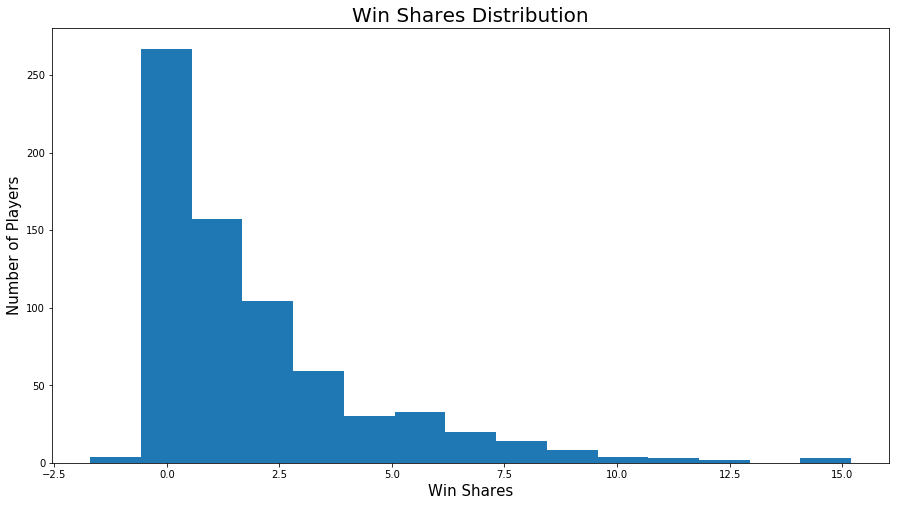

In [13]:
plt.figure(figsize = (15,8))
plt.hist(nba_data['WS'], bins = 15)
plt.xlabel('Win Shares', size = 15)
plt.ylabel('Number of Players', size = 15)
plt.title('Win Shares Distribution', size = 20);
# To check what the distibution looks like

Right away, we see that the distribution of win shares is skewed to the right. The majority of NBA players during the 2018–2019 NBA season had a win share of less than 5. This makes sense since only a selected few, mostly composed of NBA All Stars, will have very high win shares. For example, the win shares leader of the 2018–2019 NBA season was James Harden  with 15.2 win shares. So, it's an elite status to have a high win shares.

The odd takeaway from the distribution is the number of players with 0 win shares. After further analysis, I was able to find that there was a high number of players that barely played at all. Although these players are on NBA rosters, that doesn't mean they will not have significant impact to both the team and their own individual stats. Therefore, I updated the data to only include players that had played at least 41 games. Here's what the distribution of win shares looks like after cleaning out the data

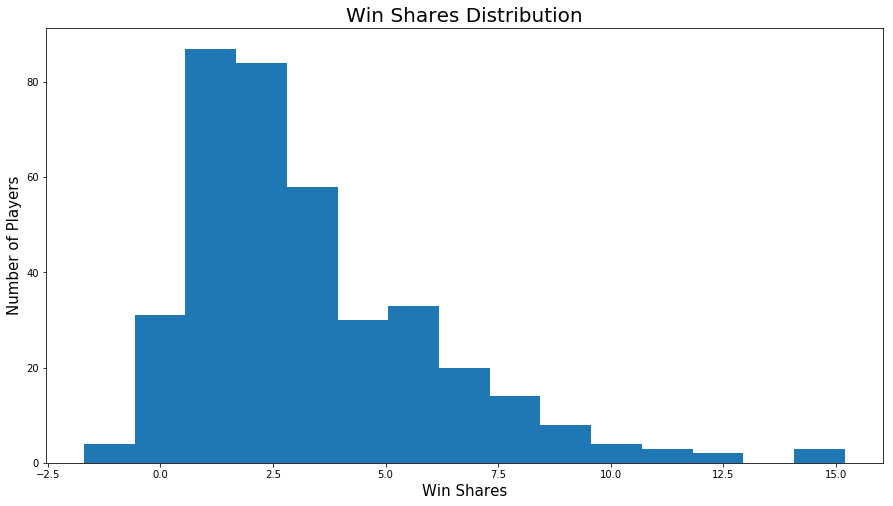

In [14]:
# There are  alot of players that have 0 WS. 
#There are 15 players in each team and need to filter out players that don't play much

nba_data = nba_data[nba_data['G'] > 41]

plt.figure(figsize = (15,8))
plt.hist(nba_data['WS'], bins = 15)
plt.xlabel('Win Shares', size = 15)
plt.ylabel('Number of Players', size = 15)
plt.title('Win Shares Distribution', size = 20);

# Filter players that has played more than 41 games. So the players that don't played much are filtered out. 
# The WS distribution is normalized compared to the last one

In [15]:
nba_data.describe()
# Now there are 381 players now. 

,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,WS,OBPM,DBPM,BPM,VORP
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,26.354331,64.356955,1552.157480,14.240420,0.556152,0.366076,0.252648,4.704987,15.380052,10.043045,14.028871,1.461680,1.730709,12.052231,18.925722,3.305249,-0.420210,-0.059843,-0.484777,0.834908
std,4.233689,12.730760,631.673093,4.605968,0.047039,0.201671,0.123188,3.710341,6.233080,4.670116,8.323237,0.536658,1.501132,3.517554,5.131376,2.747444,2.146683,1.776836,2.872955,1.484185
min,19.000000,42.000000,292.000000,5.200000,0.417000,0.000000,0.046000,0.700000,5.900000,3.700000,3.800000,0.300000,0.000000,3.700000,8.000000,-1.700000,-5.500000,-4.100000,-8.400000,-2.200000
25%,23.000000,53.000000,1064.000000,11.000000,0.526000,0.251000,0.167000,2.000000,10.700000,6.400000,7.900000,1.000000,0.700000,9.700000,15.100000,1.400000,-1.700000,-1.300000,-2.300000,-0.100000
50%,26.000000,66.000000,1499.000000,13.100000,0.555000,0.388000,0.228000,3.100000,14.100000,8.700000,11.400000,1.400000,1.300000,11.500000,18.000000,2.600000,-0.600000,-0.300000,-0.800000,0.400000
75%,29.000000,76.000000,2047.000000,17.000000,0.585000,0.522000,0.310000,6.600000,19.000000,12.700000,17.900000,1.800000,2.200000,13.900000,22.100000,4.900000,0.700000,1.100000,1.000000,1.300000
max,42.000000,82.000000,3028.000000,30.900000,0.698000,0.914000,0.879000,16.800000,35.900000,25.900000,46.500000,3.400000,10.000000,26.800000,40.500000,15.200000,10.500000,5.700000,11.700000,9.900000


In [16]:
WS_corr = nba_data.corr()['WS'].reset_index()
WS_corr = WS_corr.sort_values(['WS'], ascending = False)
WS_corr
# Going to use the variables that has .5 or more for the models

,index,WS
15,WS,1.000000
19,VORP,0.924396
18,BPM,0.868633
3,PER,0.813769
16,OBPM,0.795985
2,MP,0.698498
4,TS%,0.612444
1,G,0.537833
17,DBPM,0.441935
14,USG%,0.425792


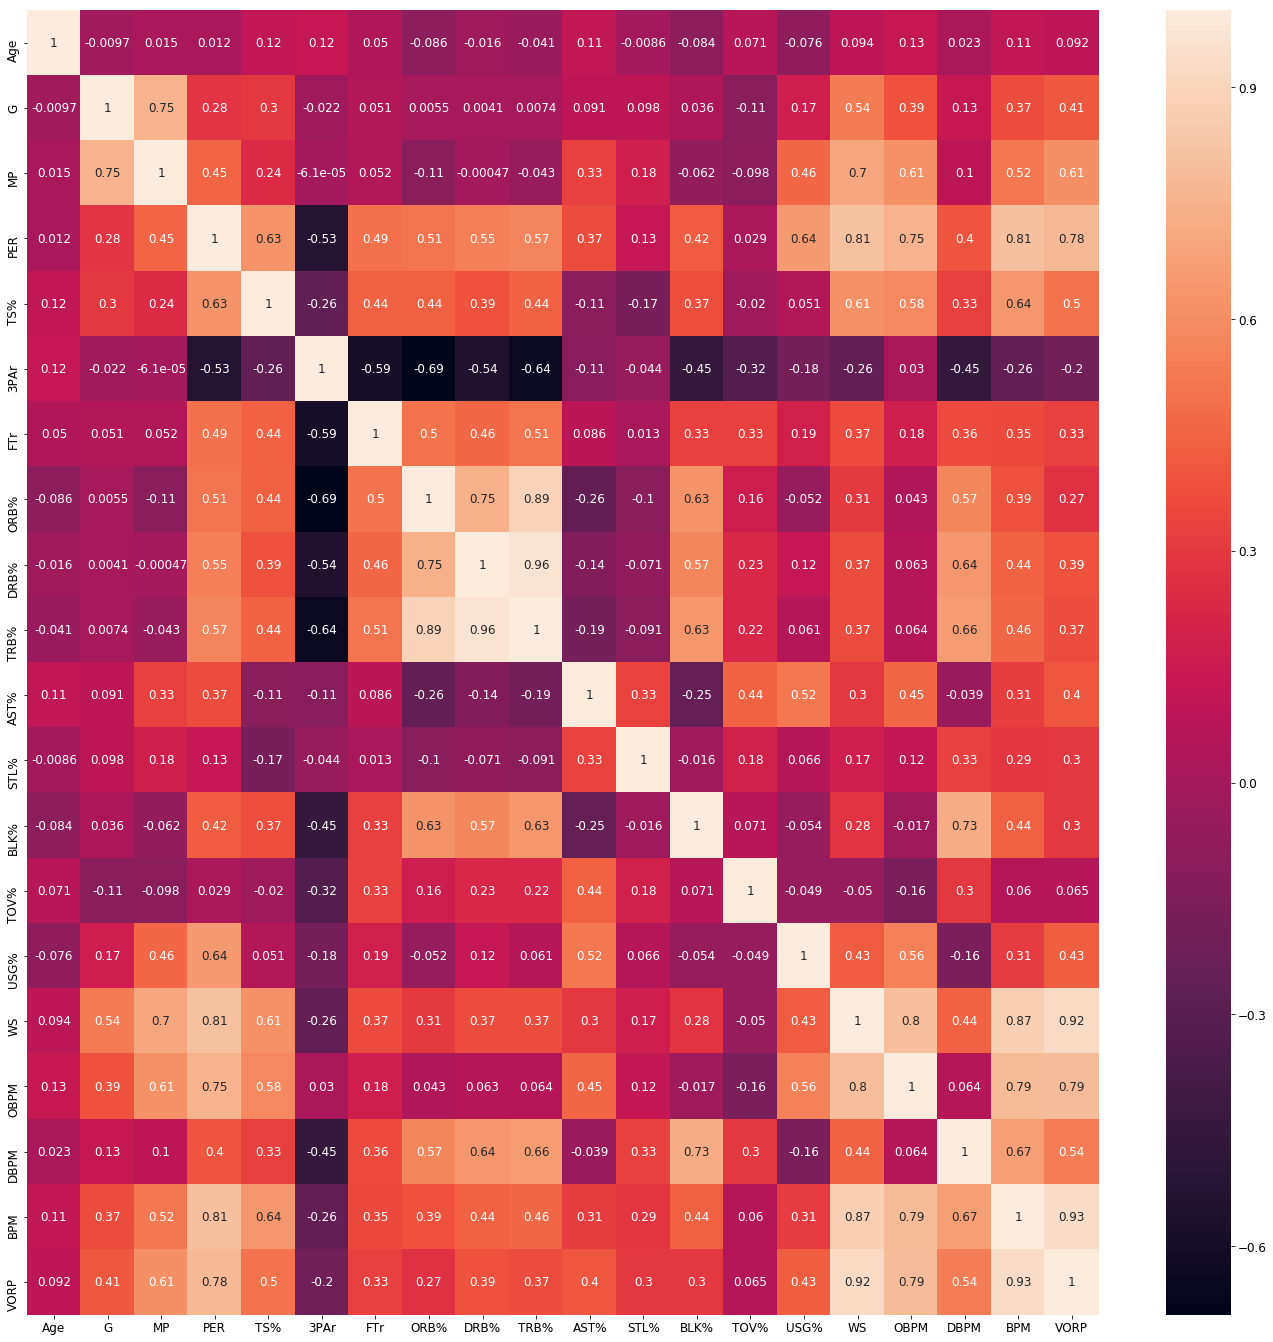

In [17]:
corr = nba_data.corr()
import seaborn as sns
plt.rcParams['figure.figsize'] = (24.0, 24.0)
plt.rcParams.update({'font.size': 12})
sns.heatmap(corr, annot=True);
# To correlation visually. 

In [18]:
nba_data.columns

Index(['Player', 'Age', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'WS', 'OBPM', 'DBPM',
       'BPM', 'VORP'],
      dtype='object')

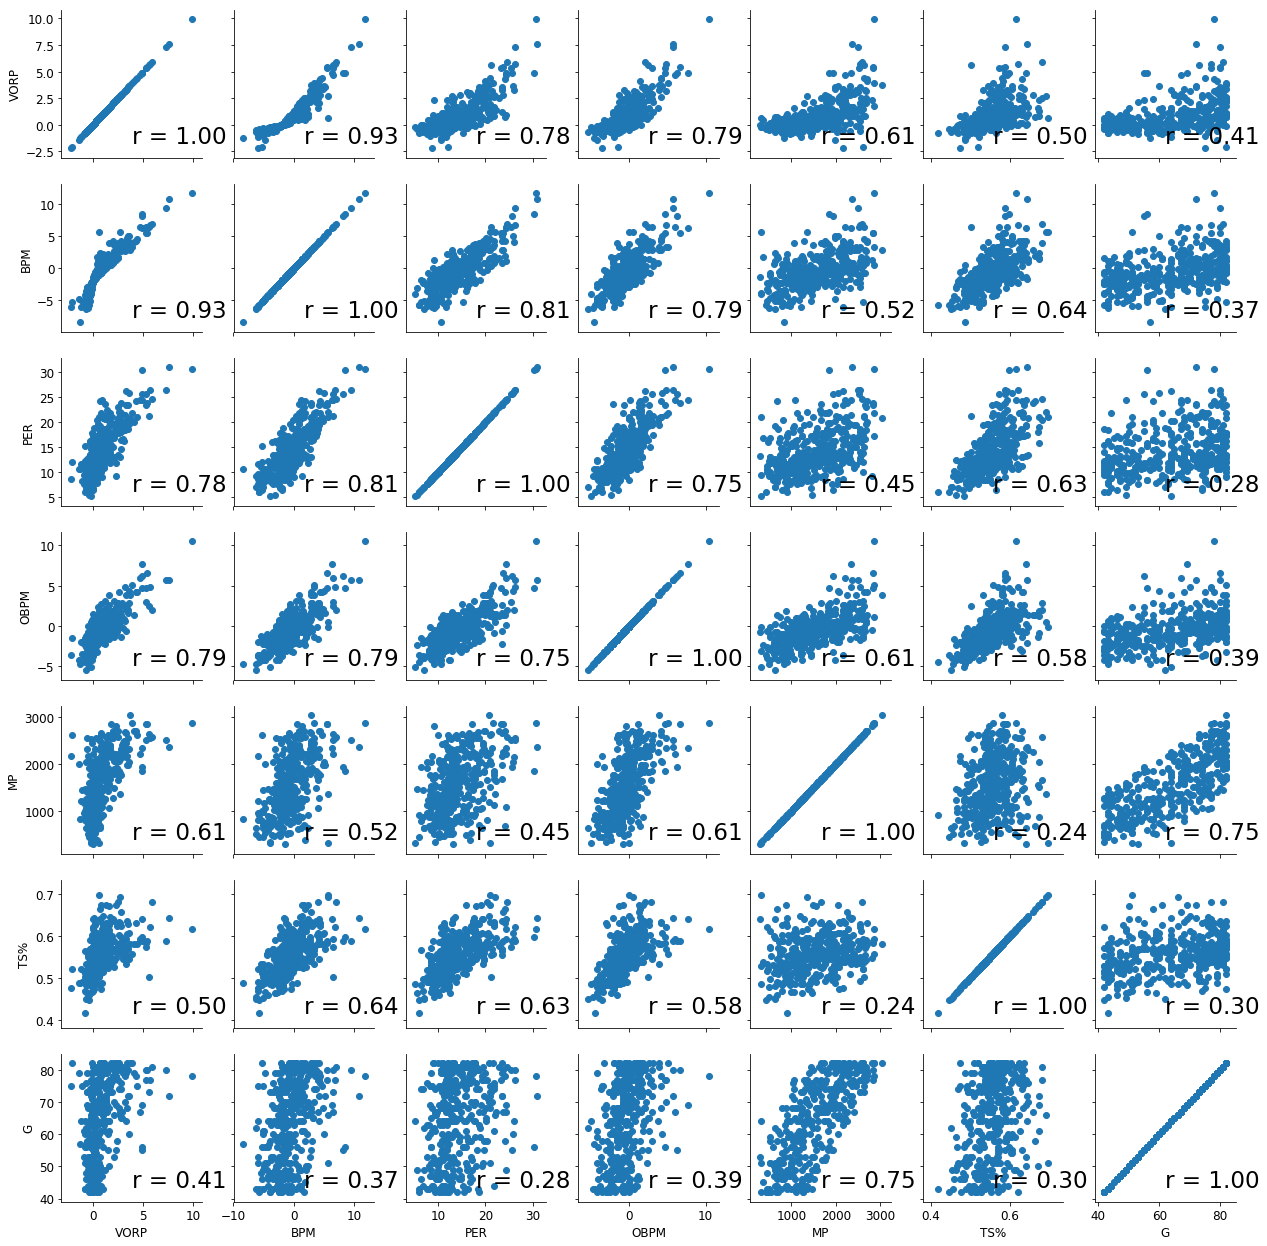

In [19]:
stats_corr = nba_data[['VORP', 'BPM', 'PER', 'OBPM', 'MP', 'TS%', 'G']]
def feature_corr(x, y, **kwargs):
    cor = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(cor),
                xy=(.5, .1),
                xycoords=ax.transAxes,
                size = 23)


plots = sb.PairGrid(stats_corr)
plots.map(plt.scatter)
plots.map(feature_corr);
# To check multicollinearity visually. 

In [20]:
stats_corr.corr()
# Checking for Multicollinearity. To see the variables are closely correlated with each other or not.

,VORP,BPM,PER,OBPM,MP,TS%,G
VORP,1.000000,0.929908,0.779450,0.794319,0.606268,0.504991,0.408920
BPM,0.929908,1.000000,0.806153,0.785744,0.521236,0.637544,0.371151
PER,0.779450,0.806153,1.000000,0.749606,0.448797,0.625866,0.281484
OBPM,0.794319,0.785744,0.749606,1.000000,0.612428,0.581164,0.387401
MP,0.606268,0.521236,0.448797,0.612428,1.000000,0.235015,0.749390
TS%,0.504991,0.637544,0.625866,0.581164,0.235015,1.000000,0.296773
G,0.408920,0.371151,0.281484,0.387401,0.749390,0.296773,1.000000


VORP vs BPM: has a very strong positive relationship (correlation of 0.93). Box Plus Minus (BPM) is a player's contribution per 100 possesions over the league average when the player was on the court. Value Over Replacement Player (VORP) takes BPM and translates it into minutes based contribution to a team. In order to calculate VORP, need to use BPM. VORP has a higher correlation with WS and uses BPM in their equation. BPM would be drop then.

There were no other correlation above 0.9. So the other variables won't be drop.

Chosen Feautures:
VORP-Value over Replacement Player
PER-Player Efficiency Rating
OBPM-Offensive Box Plus/Minus
MP- Minutes played
TS%- True Shooting Percentage 
G- Games Played


# To Check for outliers in the chosen Features. 

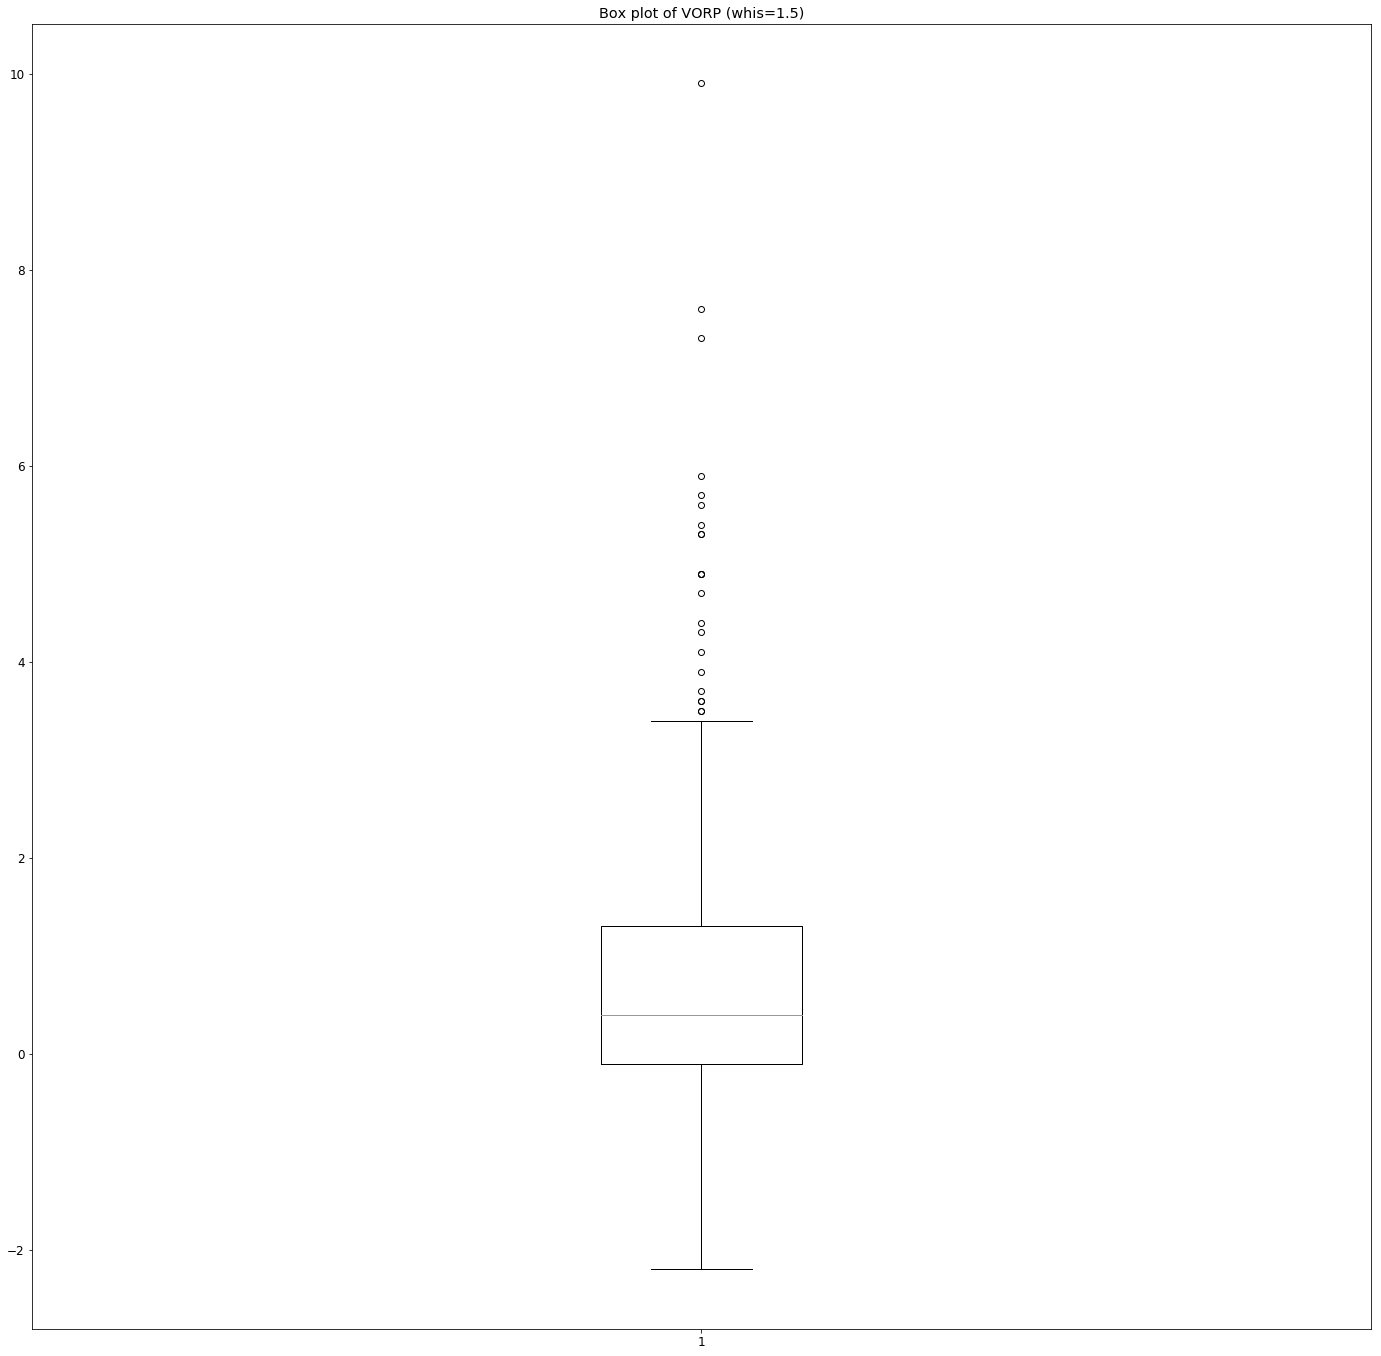

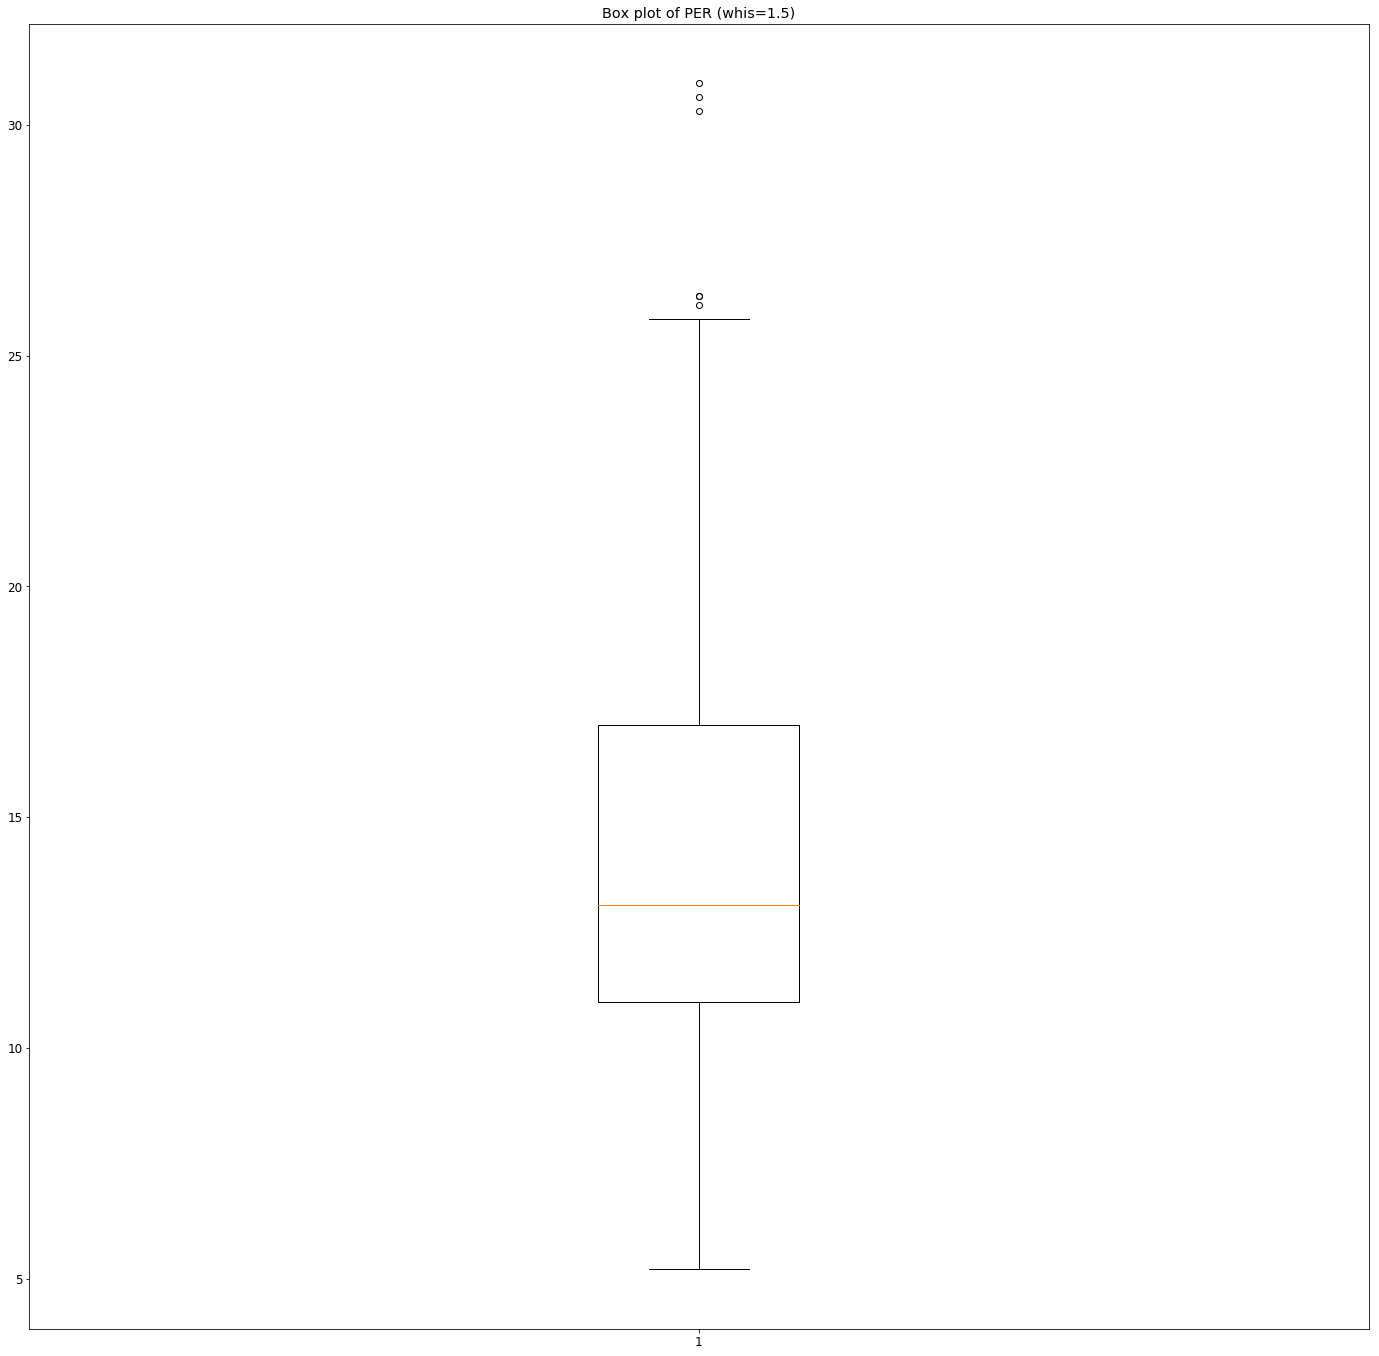

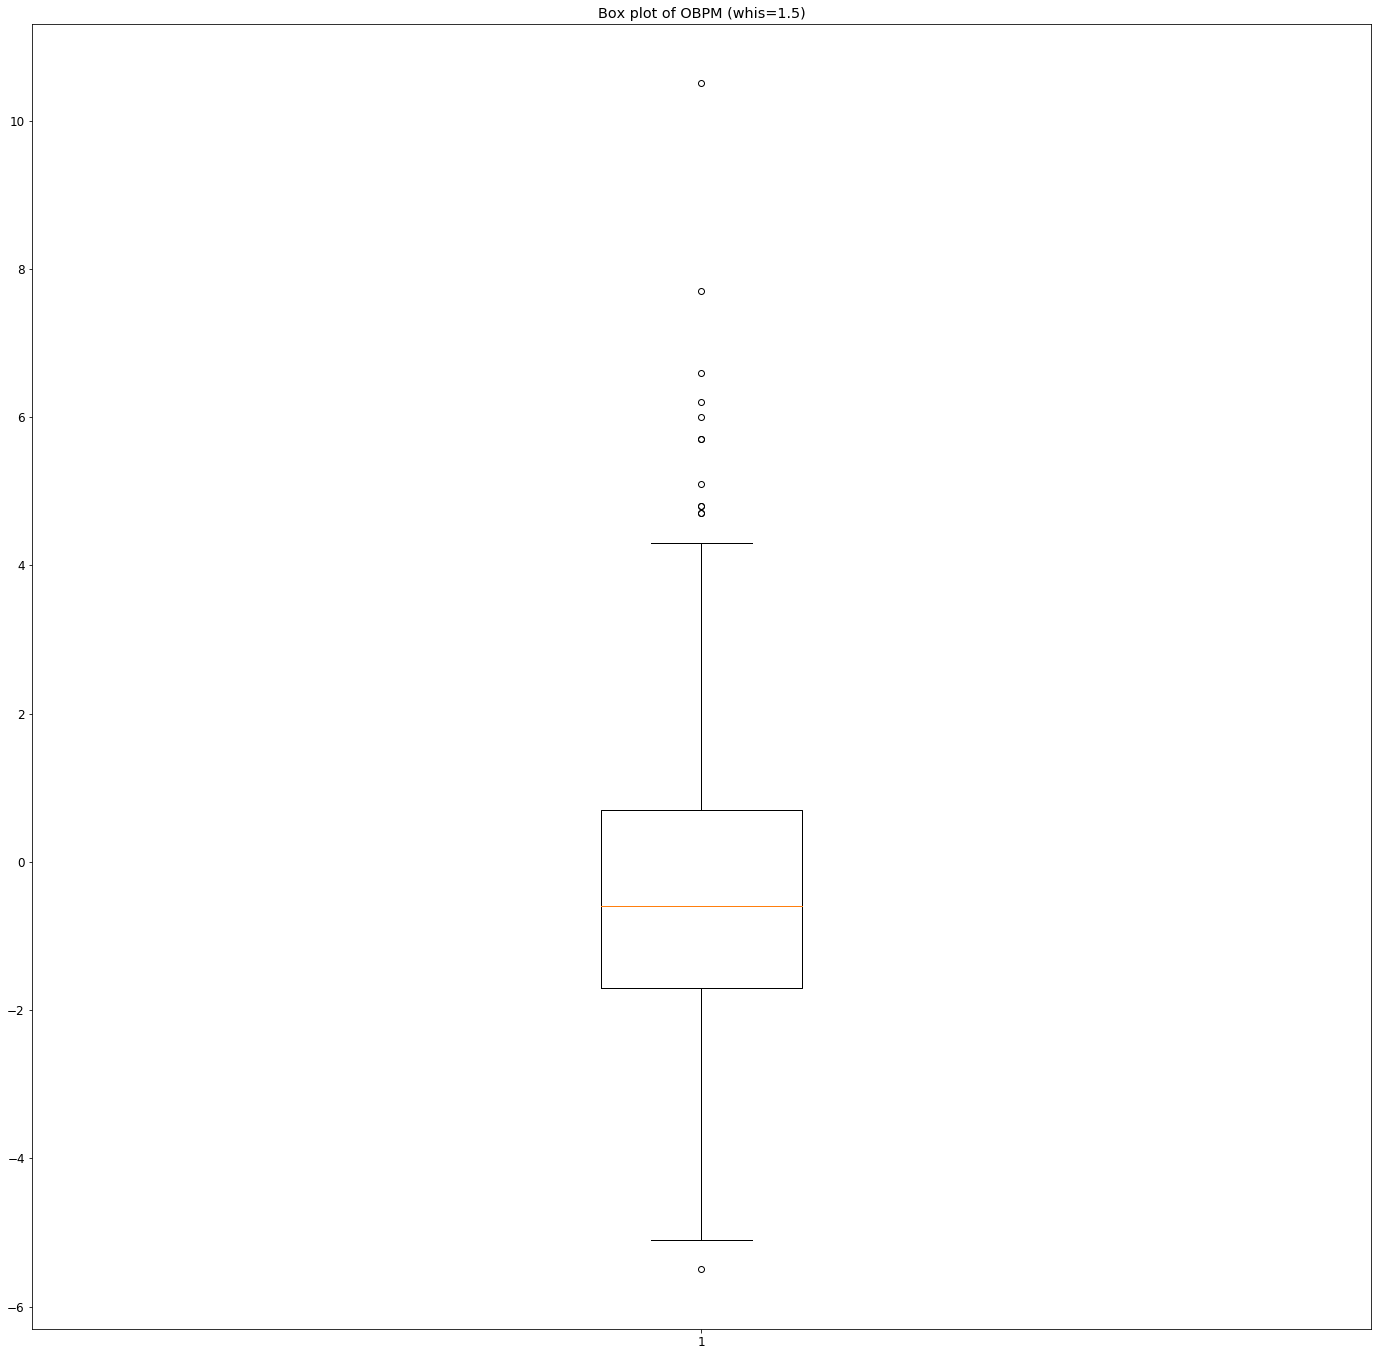

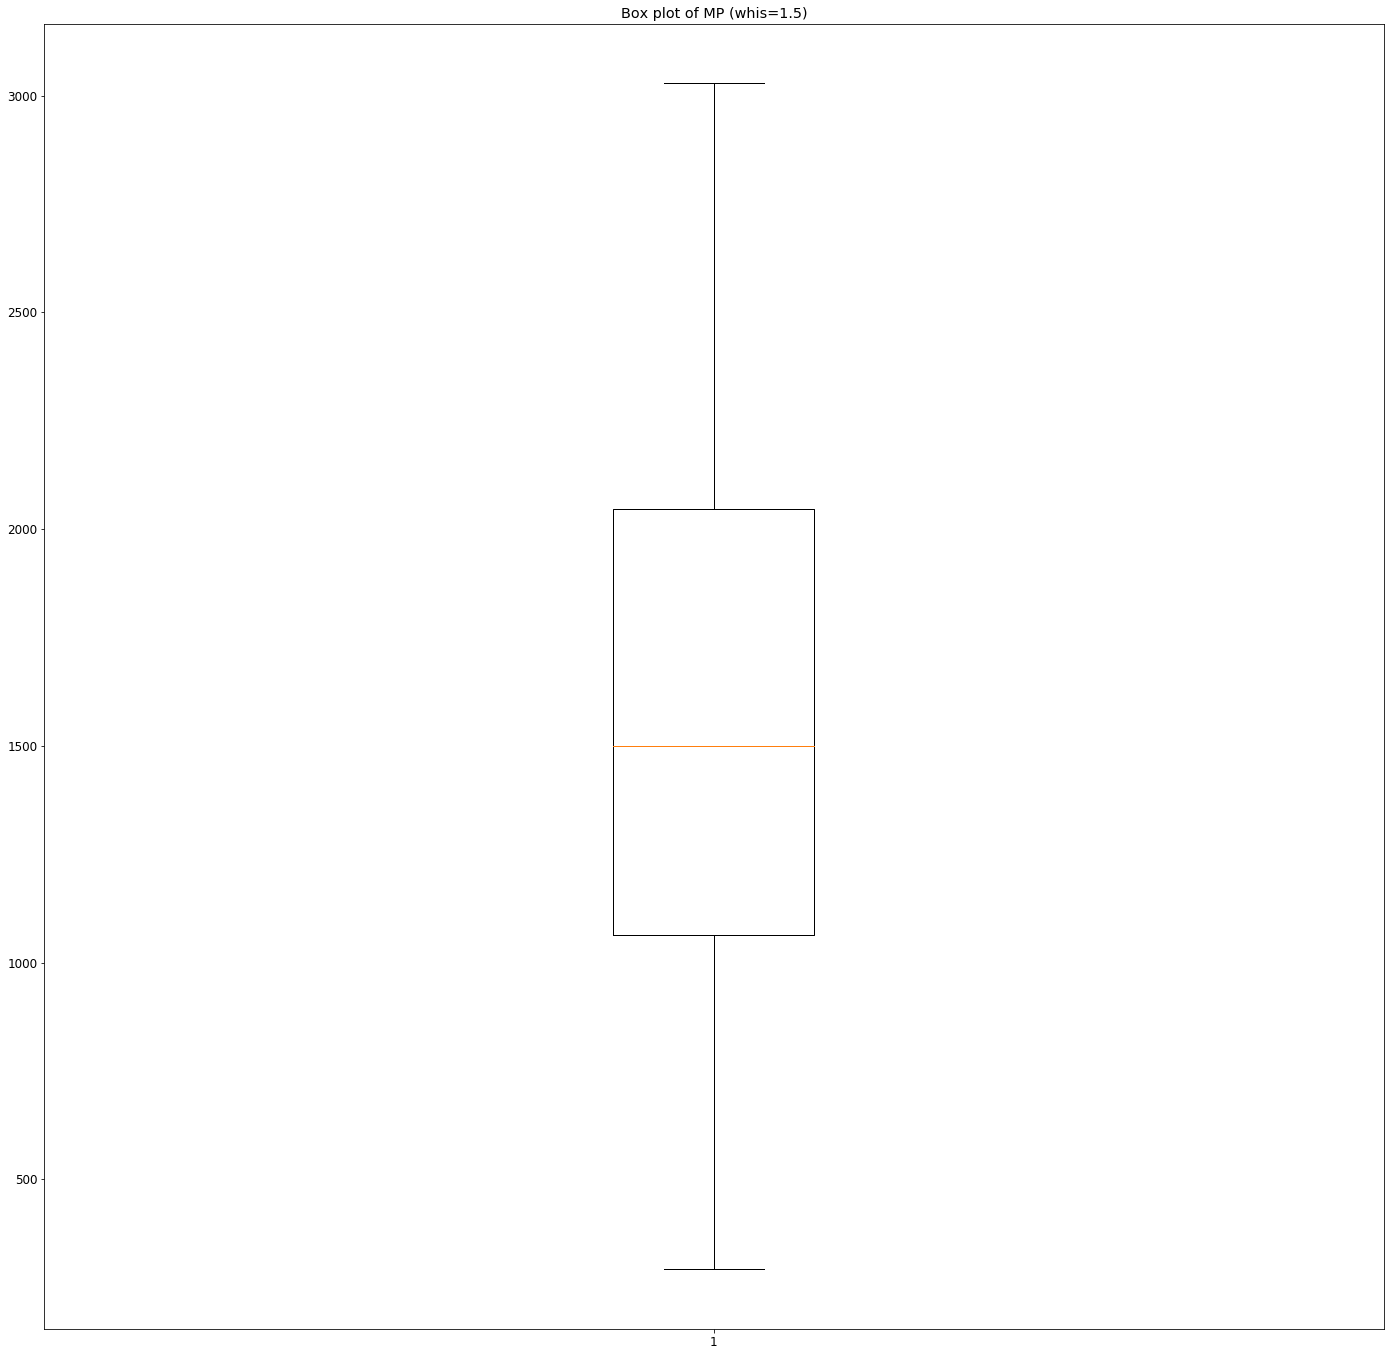

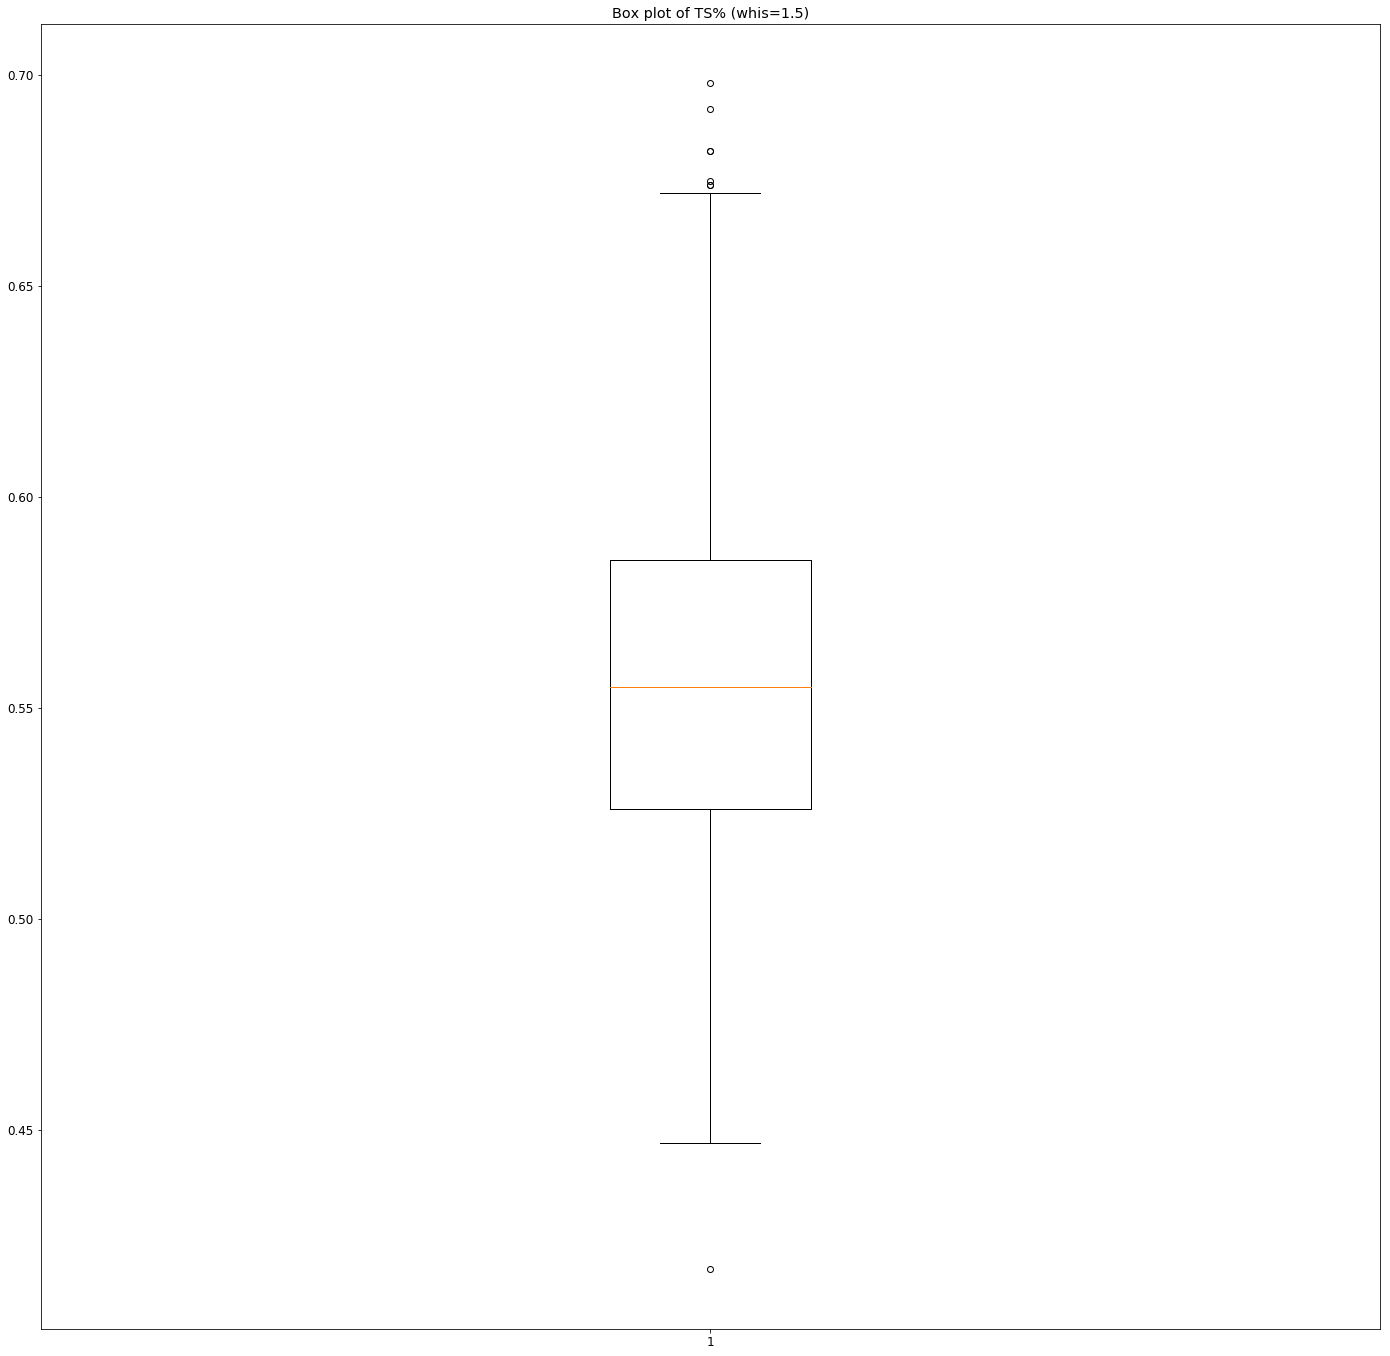

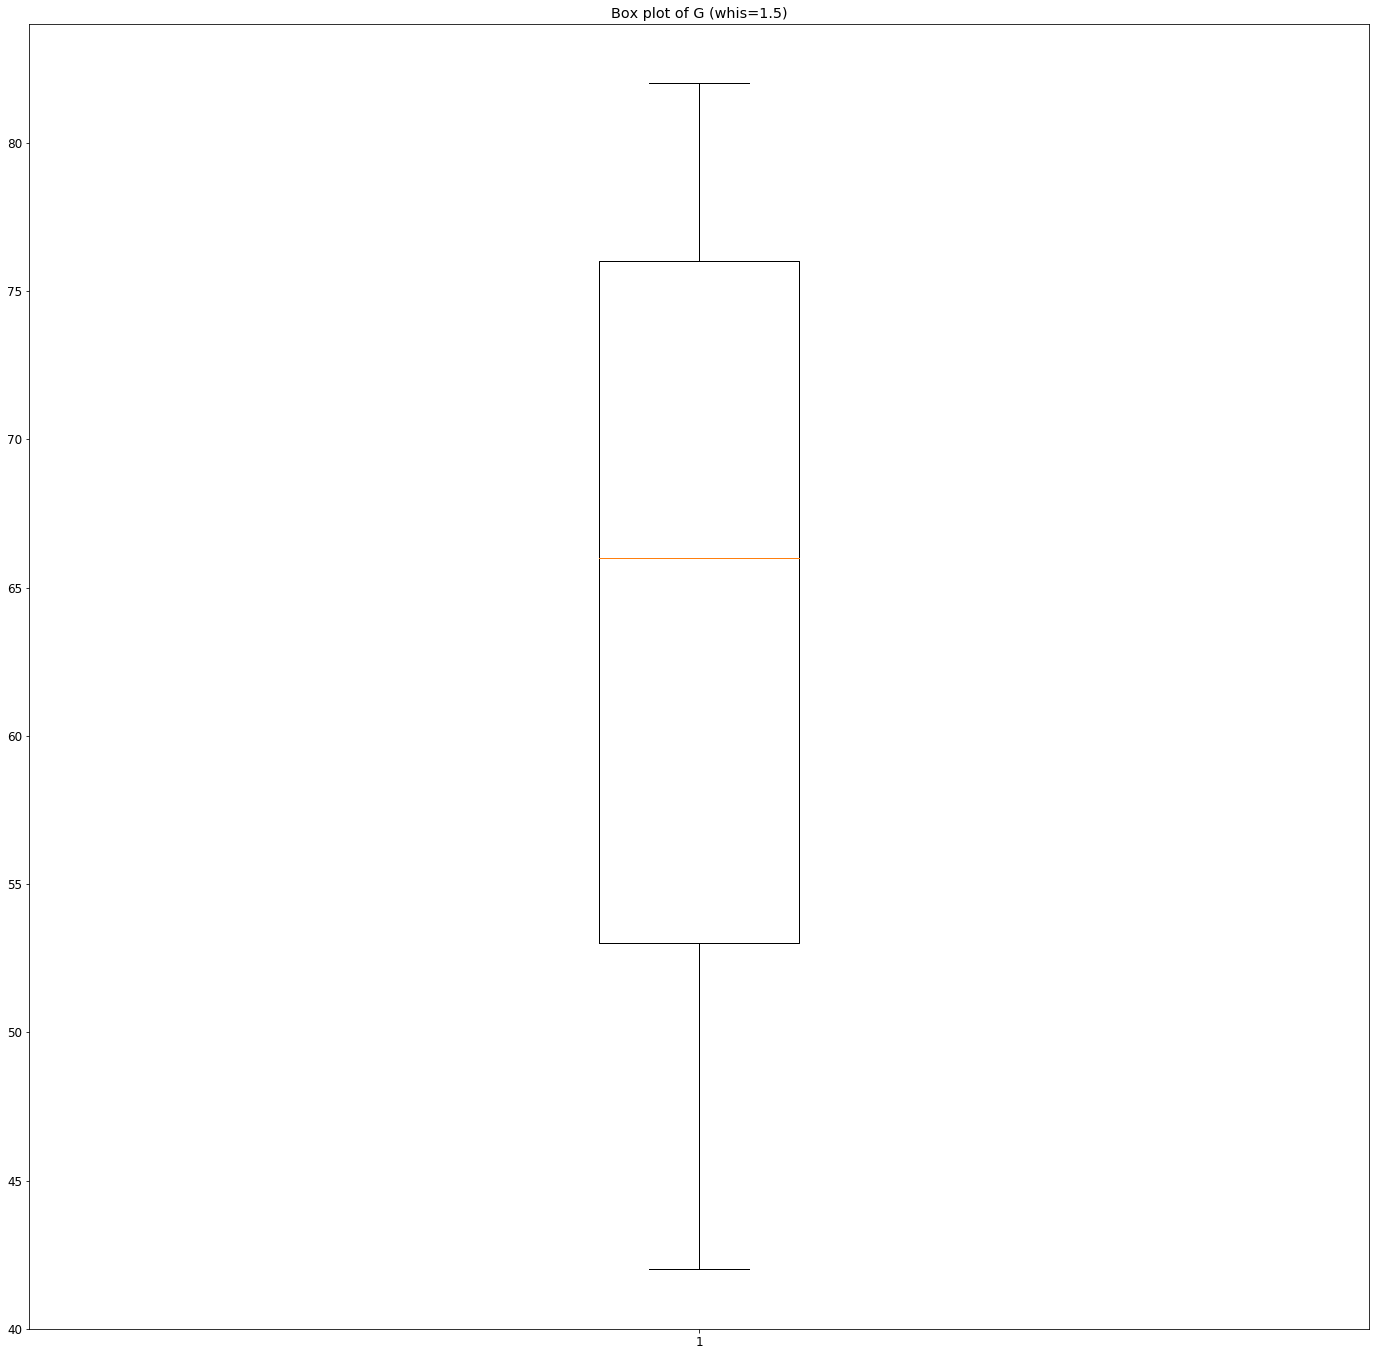

In [21]:
plt.boxplot(nba_data["VORP"])
plt.title("Box plot of VORP (whis=1.5)")
plt.show()

plt.boxplot(nba_data["PER"])
plt.title("Box plot of PER (whis=1.5)")
plt.show()

plt.boxplot(nba_data["OBPM"])
plt.title("Box plot of OBPM (whis=1.5)")
plt.show()

plt.boxplot(nba_data["MP"])
plt.title("Box plot of MP (whis=1.5)")
plt.show()

plt.boxplot(nba_data["TS%"])
plt.title("Box plot of TS% (whis=1.5)")
plt.show()

plt.boxplot(nba_data["G"])
plt.title("Box plot of G (whis=1.5)")
plt.show()

So VORP and OBPM has tons of ouliers just by looking at the boxplot. The next step is to winsorize. Since the outliers are mostly one-sided. 

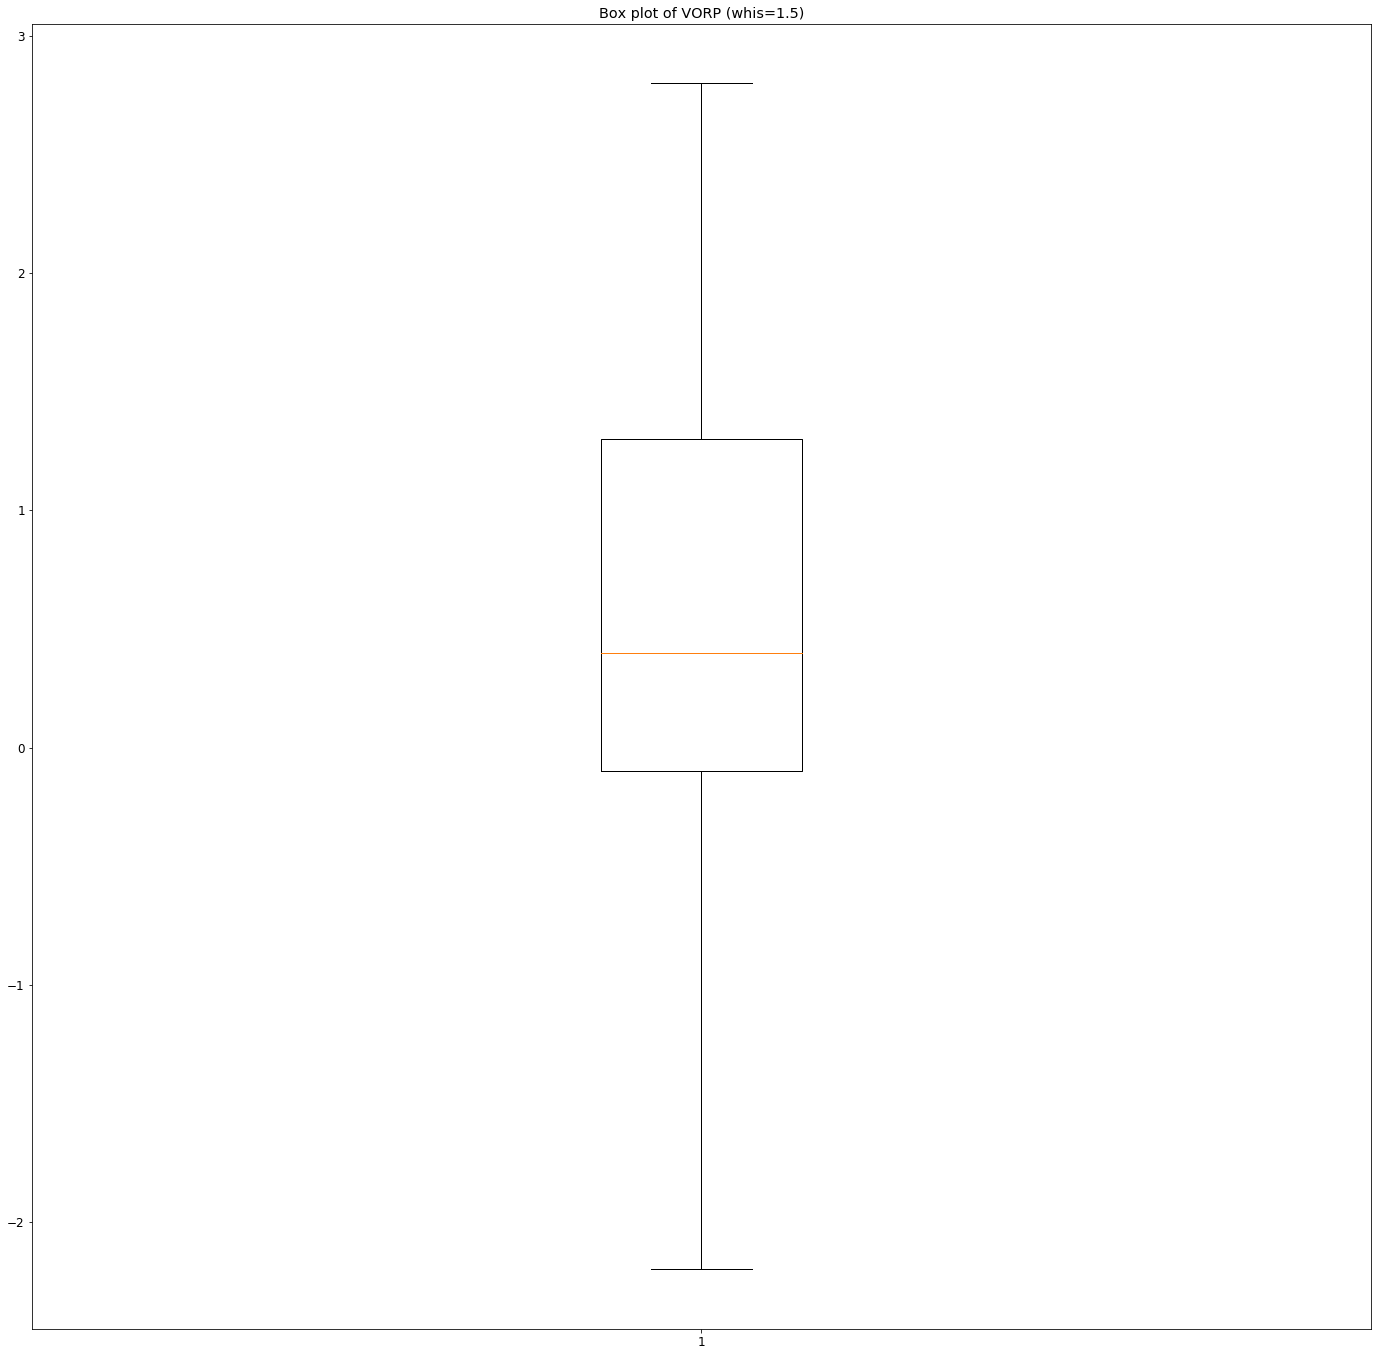

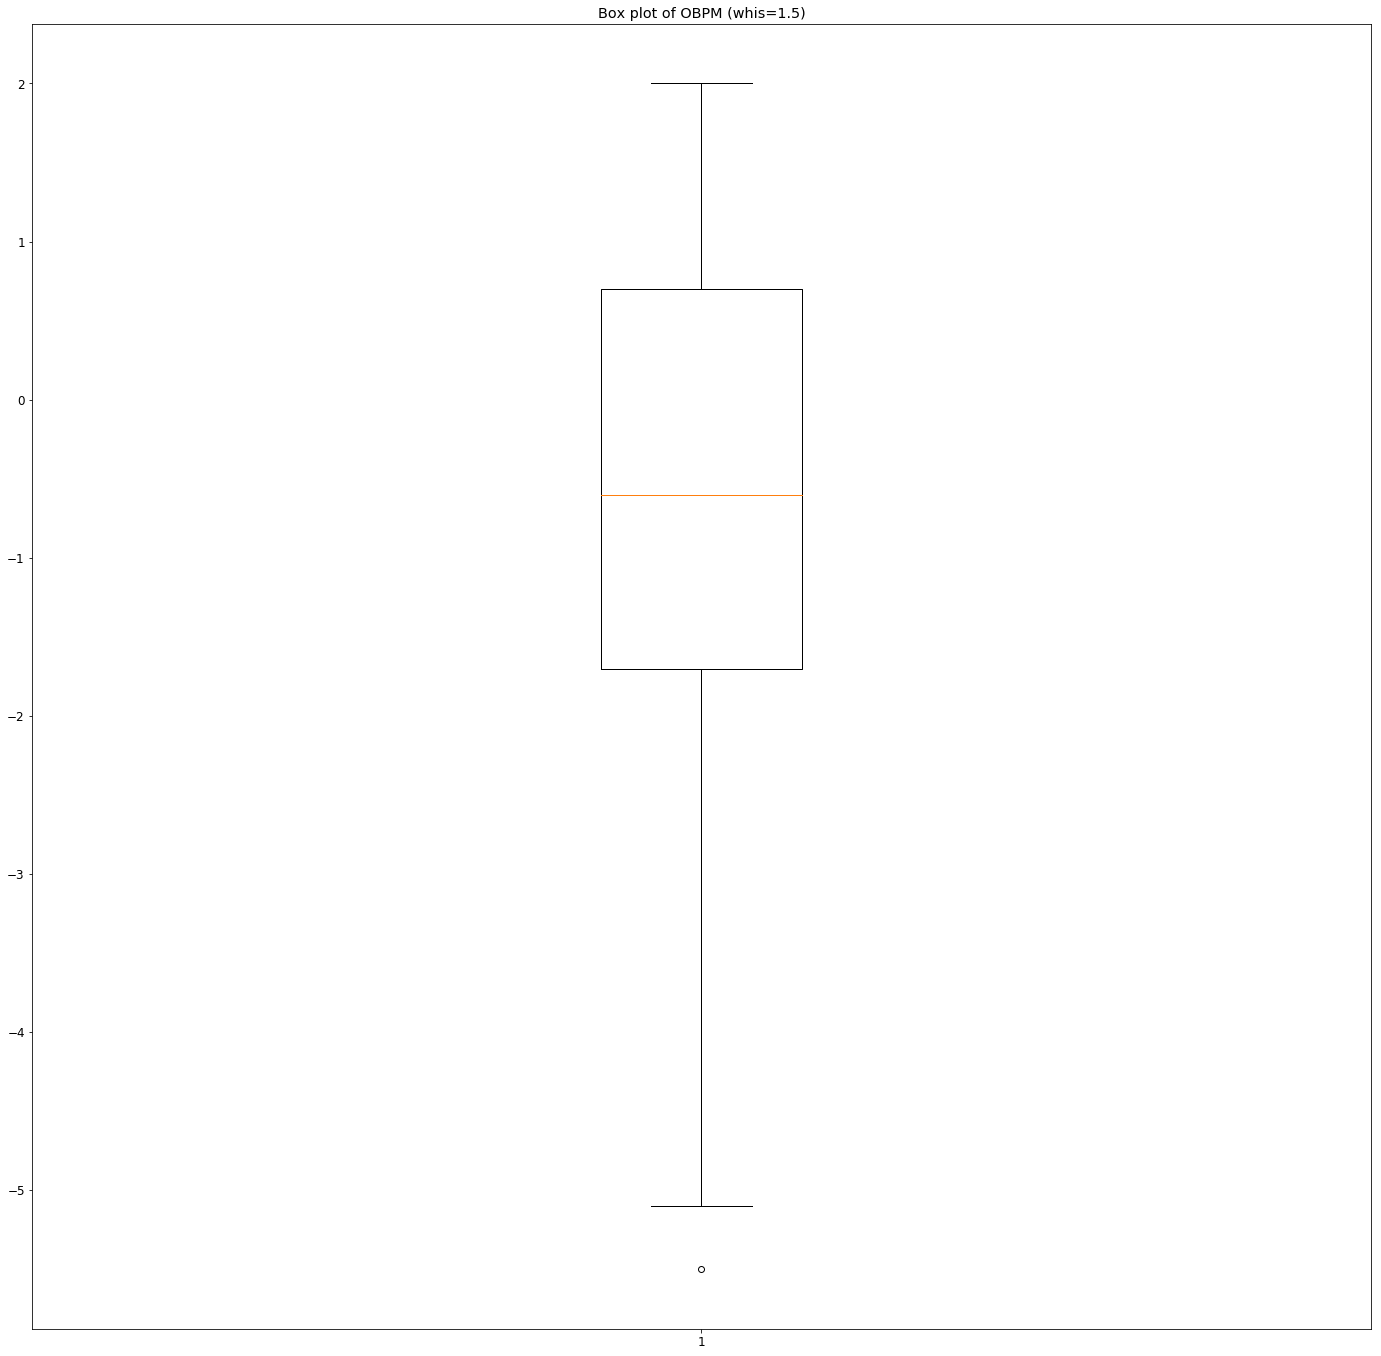

In [22]:
from scipy.stats.mstats import winsorize

# We apply one-way winsorization to the highest end
# of the value distribution. As we have a lot of extreme
# values, we set the values of the outliers to the 
# value of the 90th percentile. 
winsorized_VORP = winsorize(nba_data["VORP"], (0, 0.10))

winsorized_OBPM = winsorize(nba_data["OBPM"], (0, 0.10))

plt.boxplot(winsorized_VORP)
plt.title("Box plot of VORP (whis=1.5)")
plt.show()

plt.boxplot(winsorized_OBPM)
plt.title("Box plot of OBPM (whis=1.5)")
plt.show()

In [23]:
nba_data['winsorized_VORP'] = winsorize(nba_data["VORP"], (0, 0.10))

nba_data['winsorized_OBPM'] = winsorize(nba_data["OBPM"], (0, 0.10))

# Models

In [24]:
# Y is the target variable, in other words what are trying to predict.
Y = nba_data['WS']

# X is the feature set we are using to predict the WS
X = nba_data[['winsorized_VORP', 'PER', 'winsorized_OBPM', 'MP', 'TS%', 'G']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 7)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 304
The number of observations in test set is 77


In [25]:
# Create the Linear Regression model

linReg = linear_model.LinearRegression()
linReg.fit(X_train, y_train)

linReg.predict(X_test)

y_lin_pred = linReg.predict(X_test)

print('Score: %.3f' % linReg.score(X_train, y_train))
print('Mean squared error: %.3f' % mean_squared_error(y_test, y_lin_pred))
print('Mean Absolute error: %.3f' % mean_absolute_error(y_test, y_lin_pred))
print('Variance score: %.3f' % r2_score(y_test, y_lin_pred))

Score: 0.894
Mean squared error: 0.458
Mean Absolute error: 0.507
Variance score: 0.905


In [26]:
# Create the Support Vector Regression model

svr = SVR(kernel='rbf', gamma=1e-3, C=150, epsilon=0.3)
svr.fit(X_train, y_train.values.ravel())

y_svr_pred = svr.predict(X_test)

print('Score: %.3f' % svr.score(X_train, y_train))
print("Mean squared error: %.3f" % mean_squared_error(y_test, y_svr_pred))
print('Mean Absolute error: %.3f' % mean_absolute_error(y_test, y_svr_pred))
print('Variance score: %.3f' % r2_score(y_test, y_svr_pred))

Score: 0.988
Mean squared error: 2.834
Mean Absolute error: 1.282
Variance score: 0.415


In [27]:
# Create the k-nearest Neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors = 7, weights = 'uniform')
knn.fit(X_train, y_train)

y_knn = knn.predict(X_test)

print('Score: %.3f' % knn.score(X_train, y_train))
print("Mean Squared Error: %.3f" % mean_squared_error(y_test, y_knn))
print('Mean Absolute error: %.3f' % mean_absolute_error(y_test, y_knn))
print('Variance Score: %.3f' % r2_score(y_test, y_knn))

Score: 0.621
Mean Squared Error: 3.560
Mean Absolute error: 1.332
Variance Score: 0.265


In [28]:
# Create Random Forest Regression model
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

y_rf = rf.predict(X_test)
print('Score: %.3f' % rf.score(X_train, y_train))
print("Mean squared error: %.3f" % mean_squared_error(y_test, y_rf))
print('Mean Absolute error: %.3f' % mean_absolute_error(y_test, y_rf))
print('Variance score: %.3f' % r2_score(y_test, y_rf))

Score: 0.988
Mean squared error: 0.323
Mean Absolute error: 0.440
Variance score: 0.933


Random Forest has the lowest value of Mean Squared error and Mean Absolute Error. Also it has the highest value of Variance score. Then Linear came in second based on the errors and Variance score. Then Support Vectors is third and k-Nearest Neighbors came in last.

The next step is to look at the models visually to predict the top ten players.

In [29]:
ws = nba_data[['Player', 'WS']]

In [30]:
ws.nlargest(10, ['WS'])

,Player,WS
267,James Harden,15.2
19,Giannis Antetokounmpo,14.4
244,Rudy Gobert,14.4
401,Damian Lillard,12.1
240,Paul George,11.9
353,Nikola Joki?,11.8
191,Kevin Durant,11.5
112,Clint Capela,10.8
647,Karl-Anthony Towns,10.4
661,Nikola Vu?evi?,10.1


Top Ten players. 

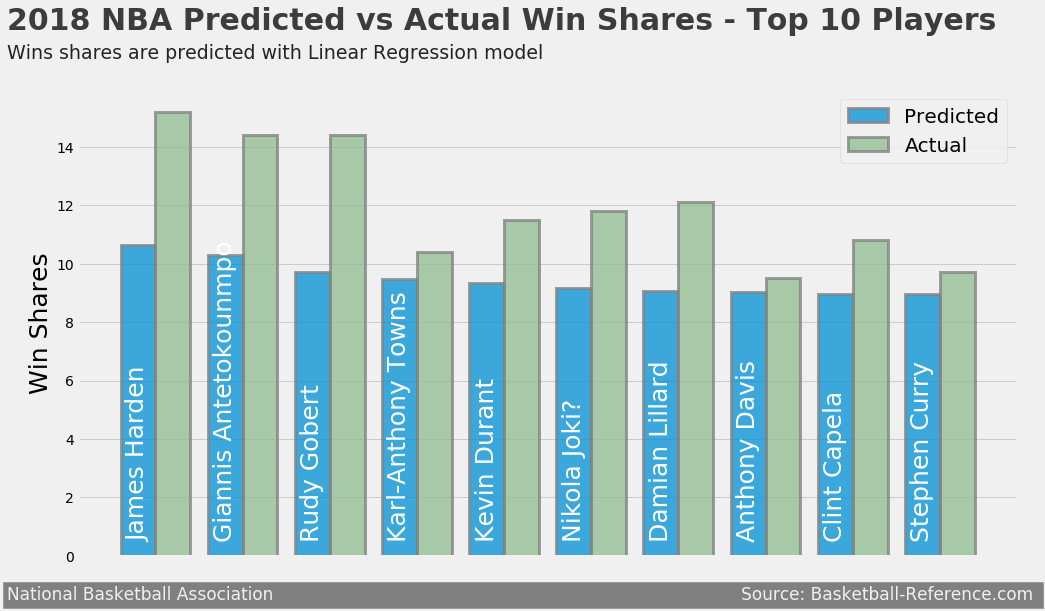

In [31]:
lin_new = nba_data[['winsorized_VORP', 'PER', 'winsorized_OBPM', 'MP', 'TS%', 'G']]

lin_pred = linReg.predict(lin_new)

lin_names = nba_data.iloc[:, 0]
a = []
for i, j in zip(lin_pred, lin_names):
    a.append({'WS_pred':i,'Player':j})

lin_wins = pd.DataFrame(a)
lin_wins['WS_pred'] = round(lin_wins['WS_pred'].astype(float),2)

lin_wins = lin_wins.sort_values([('WS_pred')], ascending = False).reset_index(drop=True).head(10)
lin_wins = lin_wins.merge(ws, on = 'Player', how = 'inner')


pos = np.arange(len(lin_wins['WS_pred']))

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(pos, lin_wins['WS_pred'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3, label = 'Predicted')
plt.bar(pos + .4, lin_wins['WS'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3, label = 'Actual',color = 'darkseagreen')
for i in pos:
    plt.text(pos[i], 0.5, s = lin_wins['Player'][i],ha='center', va='bottom', rotation = 'vertical',color = 'white', size = 25)
plt.text(x = -1.5, y = 18, s = '2018 NBA Predicted vs Actual Win Shares - Top 10 Players',fontsize = 30, weight = 'bold', alpha = .75)
plt.text(x = -1.5, y = 17, s = 'Wins shares are predicted with Linear Regression model',fontsize = 19, alpha = .85)
plt.text(x = -1.5, y = -1.5, s = 'National Basketball Association                                                                                       Source: Basketball-Reference.com ', fontsize = 17,color = '#f0f0f0', backgroundcolor = 'grey')
plt.xticks([],[])
plt.legend(prop={'size': 20})
ax.set_ylabel('Win Shares', size = 25);

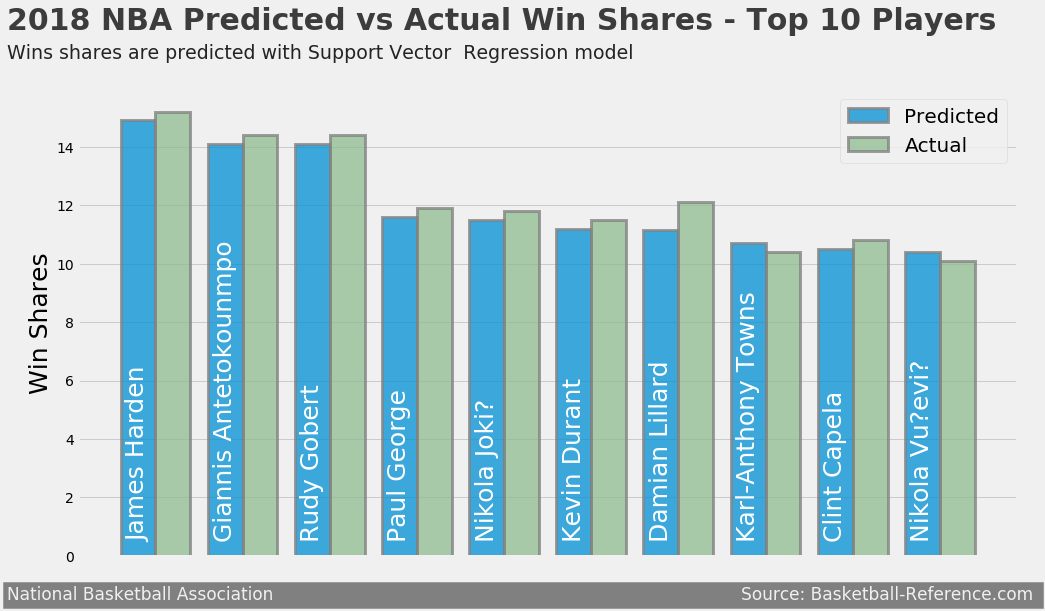

In [32]:
svr_new = nba_data[['winsorized_VORP', 'PER', 'winsorized_OBPM', 'MP', 'TS%', 'G']]

svr_pred = svr.predict(svr_new)

svr_names = nba_data.iloc[:, 0]
a = []
for i, j in zip(svr_pred, svr_names):
    a.append({'WS_pred':i,'Player':j})

svr_wins = pd.DataFrame(a)
svr_wins['WS_pred'] = round(svr_wins['WS_pred'].astype(float),2)

svr_wins = svr_wins.sort_values([('WS_pred')], ascending = False).reset_index(drop=True).head(10)
svr_wins = svr_wins.merge(ws, on = 'Player', how = 'inner')


pos = np.arange(len(svr_wins['WS_pred']))

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(pos, svr_wins['WS_pred'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3, label = 'Predicted')
plt.bar(pos + .4, svr_wins['WS'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3, label = 'Actual',color = 'darkseagreen')
for i in pos:
    plt.text(pos[i], 0.5, s = svr_wins['Player'][i],ha='center', va='bottom', rotation = 'vertical',color = 'white', size = 25)
plt.text(x = -1.5, y = 18, s = '2018 NBA Predicted vs Actual Win Shares - Top 10 Players',fontsize = 30, weight = 'bold', alpha = .75)
plt.text(x = -1.5, y = 17, s = 'Wins shares are predicted with Support Vector  Regression model',fontsize = 19, alpha = .85)
plt.text(x = -1.5, y = -1.5, s = 'National Basketball Association                                                                                       Source: Basketball-Reference.com ', fontsize = 17,color = '#f0f0f0', backgroundcolor = 'grey')
plt.xticks([],[])
plt.legend(prop={'size': 20})
ax.set_ylabel('Win Shares', size = 25);

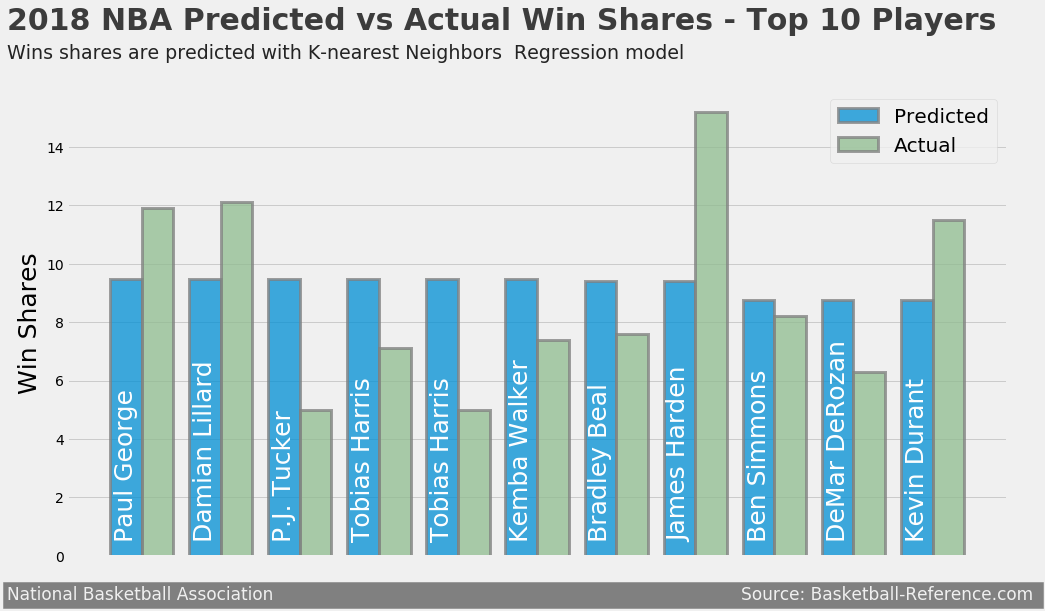

In [33]:
knn_new = nba_data[['winsorized_VORP', 'PER', 'winsorized_OBPM', 'MP', 'TS%', 'G']]

knn_pred = knn.predict(knn_new)

knn_names = nba_data.iloc[:, 0]
a = []
for i, j in zip(knn_pred, knn_names):
    a.append({'WS_pred':i,'Player':j})

knn_wins = pd.DataFrame(a)
knn_wins['WS_pred'] = round(knn_wins['WS_pred'].astype(float),2)

knn_wins = knn_wins.sort_values([('WS_pred')], ascending = False).reset_index(drop=True).head(10)
knn_wins = knn_wins.merge(ws, on = 'Player', how = 'inner')


pos = np.arange(len(knn_wins['WS_pred']))

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(pos, knn_wins['WS_pred'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3, label = 'Predicted')
plt.bar(pos + .4, knn_wins['WS'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3, label = 'Actual',color = 'darkseagreen')
for i in pos:
    plt.text(pos[i], 0.5, s = knn_wins['Player'][i],ha='center', va='bottom', rotation = 'vertical',color = 'white', size = 25)
plt.text(x = -1.5, y = 18, s = '2018 NBA Predicted vs Actual Win Shares - Top 10 Players',fontsize = 30, weight = 'bold', alpha = .75)
plt.text(x = -1.5, y = 17, s = 'Wins shares are predicted with K-nearest Neighbors  Regression model',fontsize = 19, alpha = .85)
plt.text(x = -1.5, y = -1.5, s = 'National Basketball Association                                                                                       Source: Basketball-Reference.com ', fontsize = 17,color = '#f0f0f0', backgroundcolor = 'grey')
plt.xticks([],[])
plt.legend(prop={'size': 20})
ax.set_ylabel('Win Shares', size = 25);

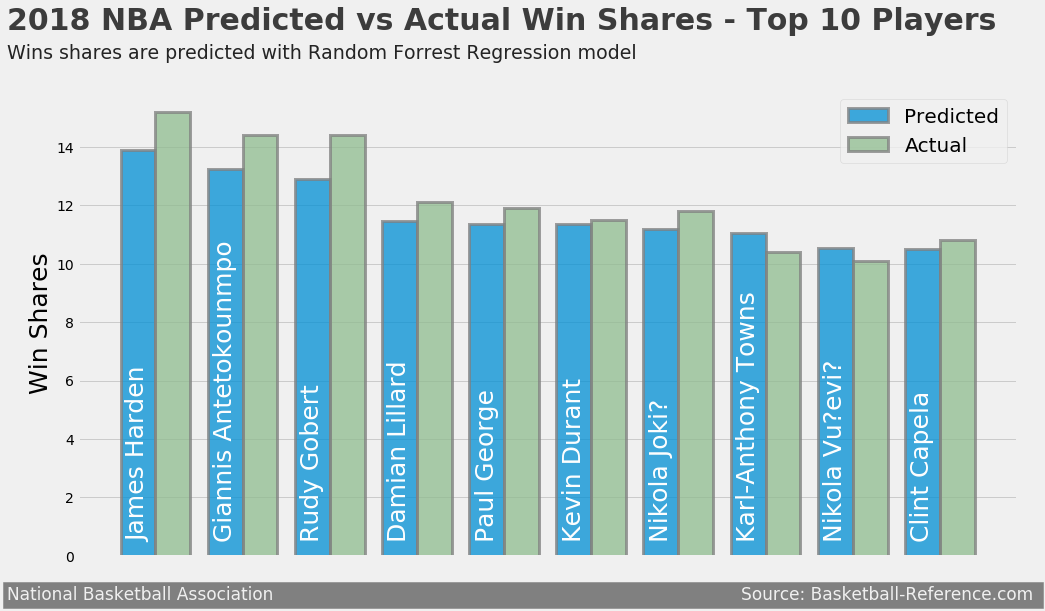

In [34]:
rf_new = nba_data[['winsorized_VORP', 'PER', 'winsorized_OBPM', 'MP', 'TS%', 'G']]

rf_pred = rf.predict(rf_new)

rf_names = nba_data.iloc[:, 0]
a = []
for i, j in zip(rf_pred, rf_names):
    a.append({'WS_pred':i,'Player':j})

rf_wins = pd.DataFrame(a)
rf_wins['WS_pred'] = round(rf_wins['WS_pred'].astype(float),2)

rf_wins = rf_wins.sort_values([('WS_pred')], ascending = False).reset_index(drop=True).head(10)
rf_wins = rf_wins.merge(ws, on = 'Player', how = 'inner')


pos = np.arange(len(rf_wins['WS_pred']))

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(pos, rf_wins['WS_pred'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3, label = 'Predicted')
plt.bar(pos + .4, rf_wins['WS'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3, label = 'Actual',color = 'darkseagreen')
for i in pos:
    plt.text(pos[i], 0.5, s = rf_wins['Player'][i],ha='center', va='bottom', rotation = 'vertical',color = 'white', size = 25)
plt.text(x = -1.5, y = 18, s = '2018 NBA Predicted vs Actual Win Shares - Top 10 Players',fontsize = 30, weight = 'bold', alpha = .75)
plt.text(x = -1.5, y = 17, s = 'Wins shares are predicted with Random Forrest Regression model',fontsize = 19, alpha = .85)
plt.text(x = -1.5, y = -1.5, s = 'National Basketball Association                                                                                       Source: Basketball-Reference.com ', fontsize = 17,color = '#f0f0f0', backgroundcolor = 'grey')
plt.xticks([],[])
plt.legend(prop={'size': 20})
ax.set_ylabel('Win Shares', size = 25);

In [35]:
lin_wins


,Player,WS_pred,WS
0,James Harden,10.62,15.2
1,Giannis Antetokounmpo,10.28,14.4
2,Rudy Gobert,9.72,14.4
3,Karl-Anthony Towns,9.47,10.4
4,Kevin Durant,9.33,11.5
5,Nikola Joki?,9.17,11.8
6,Damian Lillard,9.05,12.1
7,Anthony Davis,9.04,9.5
8,Clint Capela,8.96,10.8
9,Stephen Curry,8.95,9.7


In [36]:
svr_wins

,Player,WS_pred,WS
0,James Harden,14.90,15.2
1,Giannis Antetokounmpo,14.10,14.4
2,Rudy Gobert,14.10,14.4
3,Paul George,11.60,11.9
4,Nikola Joki?,11.50,11.8
5,Kevin Durant,11.20,11.5
6,Damian Lillard,11.15,12.1
7,Karl-Anthony Towns,10.70,10.4
8,Clint Capela,10.50,10.8
9,Nikola Vu?evi?,10.40,10.1


In [37]:
knn_wins

,Player,WS_pred,WS
0,Paul George,9.47,11.9
1,Damian Lillard,9.47,12.1
2,P.J. Tucker,9.47,5.0
3,Tobias Harris,9.47,7.1
4,Tobias Harris,9.47,5.0
5,Kemba Walker,9.47,7.4
6,Bradley Beal,9.39,7.6
7,James Harden,9.39,15.2
8,Ben Simmons,8.74,8.2
9,DeMar DeRozan,8.74,6.3


In [38]:
rf_wins

,Player,WS_pred,WS
0,James Harden,13.88,15.2
1,Giannis Antetokounmpo,13.22,14.4
2,Rudy Gobert,12.89,14.4
3,Damian Lillard,11.46,12.1
4,Paul George,11.36,11.9
5,Kevin Durant,11.35,11.5
6,Nikola Joki?,11.20,11.8
7,Karl-Anthony Towns,11.06,10.4
8,Nikola Vu?evi?,10.55,10.1
9,Clint Capela,10.49,10.8


The best model for this dataset is the random forest. It has the correct top ten players with the most win shares but not in corerect order though. Some of the players' WS are less than one decimal from each other. I'll still take it because the absolute error of the model is .440. If I can lower the error, it's possible to get correct order for the players though. The next step to check if the model is overfitted or not and to see has good generalizations. 

# Random Forrest to Check for Overfitted

In [39]:
# Y is the target variable, in other words what are trying to predict.
Y = nba_data['WS']

# X is the feature set we are using to predict the WS
X = nba_data[['winsorized_VORP', 'PER', 'winsorized_OBPM', 'MP', 'TS%', 'G']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state = 7)
# Testing 50% and training 50%
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 190
The number of observations in test set is 191


In [40]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

y_rf = rf.predict(X_test)
print('Score: %.3f' % rf.score(X_train, y_train))
print("Mean squared error: %.3f" % mean_squared_error(y_test, y_rf))
print('Mean Absolute error: %.3f' % mean_absolute_error(y_test, y_rf))
print('Variance score: %.3f' % r2_score(y_test, y_rf))

Score: 0.989
Mean squared error: 0.647
Mean Absolute error: 0.557
Variance score: 0.908


In [41]:
# Y is the target variable, in other words what are trying to predict.
Y = nba_data['WS']

# X is the feature set we are using to predict the WS
X = nba_data[['winsorized_VORP', 'PER', 'winsorized_OBPM', 'MP', 'TS%', 'G']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.9, random_state = 7)
# Testing 90% and training 10%
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 38
The number of observations in test set is 343


In [42]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

y_rf = rf.predict(X_test)
print('Score: %.3f' % rf.score(X_train, y_train))
print("Mean squared error: %.3f" % mean_squared_error(y_test, y_rf))
print('Mean Absolute error: %.3f' % mean_absolute_error(y_test, y_rf))
print('Variance score: %.3f' % r2_score(y_test, y_rf))

Score: 0.975
Mean squared error: 1.000
Mean Absolute error: 0.705
Variance score: 0.866


In [43]:
# Y is the target variable, in other words what are trying to predict.
Y = nba_data['WS']

# X is the feature set we are using to predict the WS
X = nba_data[['winsorized_VORP', 'PER', 'winsorized_OBPM', 'MP', 'TS%', 'G']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 7)
# Testing 10% and training 90%
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 342
The number of observations in test set is 39


In [44]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

y_rf = rf.predict(X_test)
print('Score: %.3f' % rf.score(X_train, y_train))
print("Mean squared error: %.3f" % mean_squared_error(y_test, y_rf))
print('Mean Absolute error: %.3f' % mean_absolute_error(y_test, y_rf))
print('Variance score: %.3f' % r2_score(y_test, y_rf))

Score: 0.989
Mean squared error: 0.310
Mean Absolute error: 0.467
Variance score: 0.942


As expected the values of the mean squared error and mean absolute error when the percentage of the data set gets tested. Except for Mean Absolute value for 20% because it has the lowest value. The variance score gets lower when the percentage of the dataset is increased. According to this the random forest is not overfitted because the evaluation would be quite similar. 

# Conclusion

Based out of the four models, random forest was the best predict the Ws based on the evaluation and graph. VORP tendsto favor offensive stats. VORP has the most correlation with WS according to this dataset. Moving foward, to improve the model to use for data. The data could from past seasons. Also use more stats, there are many I haven't touch yet. Overall, WS is not best stat to judge indivduals' performance due to team fit and player personnel. Also a good player could have low WS because his team has a losing record. I think WS is good for determining the team's most important pieces though. 